Data to analyis: 
           y        x1        x2
0  0.925576  1.271460  2.574402
1  0.521415  1.089680  2.108560
2  0.857811  1.989773  2.851763
3  0.798114  1.096682  2.314985
4  0.407161  1.672416  2.963635
5  0.140140  1.852033  2.568452
6  0.989027  1.855153  2.080290
7  0.045020  1.934969  2.493686
8  0.375157  1.272808  2.003244
9  0.664224  1.228849  2.661585 

Coefficients: [[ 0.82567492 -0.22113141  0.03420739]]

R2: 0.055438012352687555


Table with remainders: 
       y_tar     y_hat  remainder
0  0.925576  0.632579   0.292998
1  0.521415  0.656841  -0.135426
2  0.857811  0.483225   0.374586
3  0.798114  0.662354   0.135760
4  0.407161  0.557229  -0.150069
5  0.140140  0.503992  -0.363852
6  0.989027  0.486604   0.502423
7  0.045020  0.483095  -0.438075
8  0.375157  0.612743  -0.237586
9  0.664224  0.644984   0.019241 

Predicted values of [[0.12, 1.22], [0.34, 1.34], [0.95, 2.45]]:
 [[0.8408721697173176], [0.7963281453877938], [0.6994081857084388]]



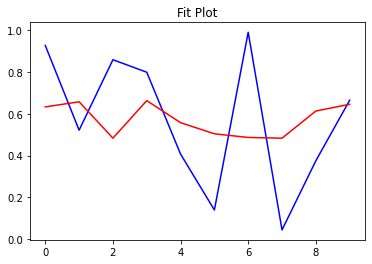

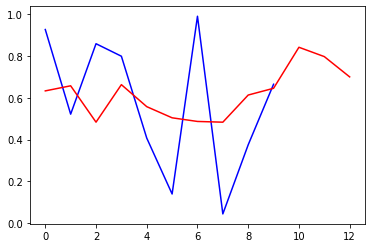

In [ ]:
class WrongColumnsNames(Exception):
    pass

class WrongLengthError(Exception):
    pass

class LinearRegression(object):
    def __init__(self, df, y_names, x_names):
        self.df = df
        self.y_names = y_names
        self.x_names = x_names
    
    #Prepare data to LSM
    @staticmethod
    def data_prep(df, x_names, y_names):
        try:
            colnames = y_names + x_names
            if all(x in df.columns.values.tolist() for x in colnames) == False:
                raise WrongColumnsNames
        except WrongColumnsNames:
            print("Check columns names!")
            sys.exit() 
        else:
            df = df[colnames]
            alpha = pd.DataFrame(np.ones(len(df)), columns = ['alpha'])
            df = pd.concat([alpha, df], axis = 1)
        return df
    
    @staticmethod
    def lsm(df, x_names, y_names):
        y = df[y_names].to_numpy()
        x = df[['alpha'] + x_names].to_numpy()
        x_t = np.transpose(x)
        #first part of formula
        f_part = np.matmul(x_t, x)
        f_part = np.linalg.inv(f_part)
        
        #second part of formula
        s_part = np.matmul(x_t, y)
        
        #out
        out = np.transpose(np.matmul(f_part, s_part))
        
        return out
    
    @staticmethod
    def y_hat(x, out):
        y_hat = np.sum(np.multiply(x, out), axis = 1)
        y_hat = np.array([y_hat]).T
        return y_hat
    
    @staticmethod
    def remainder(y_tar, y_hat):
        remainder = y_tar - y_hat
        return remainder.to_numpy()
    
    @staticmethod
    def table(y_tar, y_hat, remainder):
        y_tar = pd.DataFrame(y_tar, columns = ['y_tar'])
        y_hat = pd.DataFrame(y_hat, columns = ['y_hat'])
        remainder = pd.DataFrame(remainder, columns = ['remainder'])
        table = pd.concat([y_tar, y_hat, remainder], axis = 1)
        
        return table
    
    @staticmethod
    def r2(y_tar, y_hat):
        y_tar = y_tar.to_numpy()
        avg = np.mean(y_tar)
        down = np.sum(np.power(np.subtract(y_tar, avg), 2))
        up = np.sum(np.power(np.subtract(y_hat, avg), 2))
        coef = up/down
        
        return coef
    
    def fit(self):
        data = self.data_prep(self.df, self.x_names, self.y_names)
        
        self.lsm = self.lsm(data, self.x_names, self.y_names)
        
        y_tar = data[self.y_names].to_numpy()
        
        x = data[['alpha'] + self.x_names].to_numpy()
        y_hat = self.y_hat(x, self.lsm)
        
        remainder = self.remainder(data[self.y_names], y_hat)
        
        coef = self.r2(data[self.y_names], y_hat)
        
        FIT = namedtuple("FIT", "COEF y_tar y_hat remainder R2")
        fit = FIT(self.lsm, y_tar, y_hat, remainder, coef)
        
        return fit
    
    def predict(self, x):
        try:
            if len(self.lsm[0])-1 != x.shape[1]:
                raise WrongLengthError
        except WrongLengthError:
            print("Wrong Vector Length!")
            sys.exit()
        else:
            ones = np.ones(len(x))
            x = np.insert(x, 0, np.ones(len(x)).tolist(), axis = 1)
            y_hat = np.sum(np.multiply(x, self.lsm), axis = 1)
            y_hat = np.array([y_hat]).T
        
        return y_hat

        
if __name__ == "__main__":
    from collections import namedtuple
    import pandas as pd
    import numpy as np
    import sys
    from matplotlib import pyplot as plt
    
    data = {'y': np.random.rand(10), 'x1': np.random.rand(10)+1, 'x2': np.random.rand(10)+2}
    df = pd.DataFrame(data)
    print('Data to analyis: \n', df, '\n')

    kmnk = LinearRegression(df, ['y'], ['x1','x2'])
    fit = kmnk.fit()

    values = np.array([[0.12,1.22],[0.34,1.34],[0.95,2.45]])
    pred = (kmnk.predict(values))

    print(f'Coefficients: {fit.COEF}\n')
    print(f'R2: {fit.R2}\n')
    print('\nTable with remainders: \n', kmnk.table(fit.y_tar, fit.y_hat, fit.remainder), '\n')
    print(f'Predicted values of {values.tolist()}:\n {pred.tolist()}\n')

    #fit plot
    plt.plot(fit.y_tar, color = 'blue', label = 'y_hat')
    plt.plot(fit.y_hat, color = 'red', label = 'y_hat')
    plt.title('Fit Plot')
    plt.show()

    #plot with fit and predicted values
    plt.plot(fit.y_tar, color = 'blue', label = 'y_hat')
    plt.plot(np.append(fit.y_hat, pred), color = 'red', label = 'predicted')
    plt.show()